In [1]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
BANDIT_REWARD = [1, 2, 3, 4]
NUMBER_OF_TRIALS = 20000
EPS = 0.1

In [3]:
class Bandit(ABC):

    @abstractmethod
    def __init__(self, reward):
        self.reward = reward

    @abstractmethod
    def __repr__(self):
        pass

    @abstractmethod
    def pull(self):
        pass

    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def experiment(self):
        pass

    @abstractmethod
    def plot_learning_process(self): 
        pass

    @abstractmethod
    def report(self):
        pass

In [4]:
class EpsilonGreedy(Bandit):
    """
    An implementation of the Epsilon Greedy algorithm for multi-armed bandit problems.

    Inherits from the Bandit class.
    """
    
    def __init__(self, reward):
        """
        Constructor for the EpsilonGreedy class.
        """
        self.reward = reward
        self.reward_estimate = 0
        self.N = 0
    
    def __repr__(self):
        """
        String representation of the class.
        """
        return f'A Bandit with {self.reward} Reward'
    
    def pull(self):
        """
        Pulls the arm of the bandit and generate a random reward.
        """
        return np.random.randn() + self.reward
    
    def update(self, x):
        """
        Updates the reward estimate based on the current reward obtained.
        """
        self.N += 1
        self.reward_estimate = (1 - 1.0/self.N) * self.reward_estimate + 1.0/ self.N * x

    def experiment(self, bandit_rewards, t, N=NUMBER_OF_TRIALS):
        """
        Runs the Epsilon Greedy algorithm on a set of bandits.
        """
        bandits = [EpsilonGreedy(reward) for reward in bandit_rewards]
        
        # the number of suboptimal choices
        means = np.array(bandit_rewards)
        true_best = np.argmax(means)
        count_suboptimal = 0
                
        # empty array to later add the rewards for inference plots
        eg_rewards = np.empty(N)
        eg_selected_bandit = []
        eps = 1/t

        for i in range(N):
            #generating a random number 
            p = np.random.random() 
            
            # if the random number is smaller than eps we explore a random bandit
            if p < eps:  
                j = np.random.choice(len(bandits)) 
            else:
                # if the random number is bigger than eps we explore the bandit with the highest current reward
                j = np.argmax([b.reward_estimate for b in bandits])
            
            # pull the chosen bandit and get the output
            x = bandits[j].pull()
            
            # increases N by 1 and calculates the estimate of the reward
            bandits[j].update(x) 
            
            # if j is not the actual true best bandit, the suboptimal bandit count increments by 1
            if j != true_best: 
                count_suboptimal += 1
            
            # add the selected bandit to the list of selected bandits
            eg_selected_bandit.append(j)
            
            # add the reward to the data
            eg_rewards[i] = x
            
            # increase t, i.e., decrease the probability of choosing suboptimal (random) bandit
            t += 1
            eps = 1/t
        
        all_bandits = pd.DataFrame({"Bandit" : eg_selected_bandit, "Reward" : eg_rewards, "Algorithm" : "Epsilon Greedy"})
        all_bandits.to_csv("./csv/EpsilonGreedy_All.csv", index=False)
        
        return eg_rewards, eg_selected_bandit, bandits, count_suboptimal
    
    def plot_learning_process(self, bandit_rewards, eg_rewards, eg_selected_bandit, N=NUMBER_OF_TRIALS):
        """
        Plots the cumulative reward and regret for the algorithm.
        """
        bandits = [EpsilonGreedy(reward) for reward in bandit_rewards]
        
        actual_rewards = []
        for i in eg_selected_bandit:
            actual_rewards.append(bandits[i].reward)
            
        true_best = max(bandit_rewards)
        best_reward = np.arange(N)
        
        eg_regrets = np.cumsum(np.full_like(best_reward, true_best)) - np.cumsum(eg_rewards)   # with estimated reward
        # eg_regrets = np.cumsum(np.full_like(best_reward, true_best)) - np.cumsum(actual_rewards)   # with actual reward
        
        plt.figure(figsize=(10, 8))
        plt.plot(np.cumsum(eg_rewards), label = "Cumulative Reward", color = 'g')
        plt.plot(eg_regrets, label = "Cumulative Regret", color = 'r')
        plt.title("Cummulative Reward and Regret", fontsize=20)
        plt.xlabel("Number of Trials", fontsize=14)
        plt.ylabel("Estimated Reward", fontsize=14)
        plt.legend()
        plt.show()
        
        return eg_regrets

    def report(self, bandits, eg_rewards, eg_regrets, count_suboptimal, N=NUMBER_OF_TRIALS):
        """
        Prints the cumulative rewards and regrets, the average rewards and regrets, the suboptimal count,
        and returns a DataFrame containing the results.
        """
        print(f"Cumulative Rewards: {np.cumsum(eg_rewards)}")
        print(f"Cumulative Regrets: {np.cumsum(eg_regrets)}\n")
        print(f"Average Rewards: {np.mean(eg_rewards)}")
        print(f"Average Regrets: {np.mean(eg_regrets)}\n")
        print(f"Count of suboptimal choices: {count_suboptimal}")
        
        df = pd.DataFrame()
        for b in bandits:
            df["Bandit"] = [b for b in bandits]
            df["Reward"] = [b.reward_estimate for b in bandits]
            df["Algorithm"] = "EpsilonGreedy"
        
        df.to_csv("./csv/EpsilonGreedy_Last.csv", index=False)
        
        return df

In [5]:
eg_rewards, eg_selected_bandit, bandits, count_suboptimal = EpsilonGreedy(Bandit).experiment(BANDIT_REWARD, 10) # t=10 -> eps = 1/t = 0.1

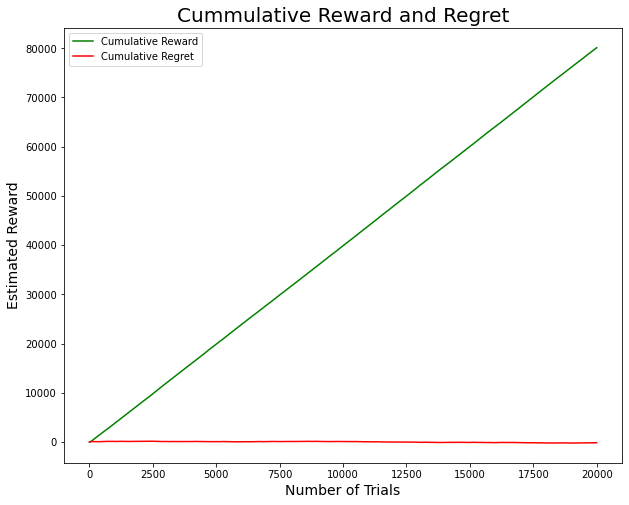

In [6]:
eg_regrets = EpsilonGreedy(Bandit).plot_learning_process(BANDIT_REWARD, eg_rewards, eg_selected_bandit)

In [7]:
df = EpsilonGreedy(Bandit).report(bandits, eg_rewards, eg_regrets, count_suboptimal)

Cumulative Rewards: [1.96332853e+00 3.94812061e+00 5.03767884e+00 ... 8.01031046e+04
 8.01078467e+04 8.01135249e+04]
Cumulative Regrets: [2.03667147e+00 6.08855087e+00 1.30508720e+01 ... 7.38240532e+05
 7.38128685e+05 7.38015160e+05]

Average Rewards: 4.0056762467634295
Average Regrets: 36.90075800290237

Count of suboptimal choices: 82


In [8]:
class ThompsonSampling(Bandit):
    """
    An implementation of the Thompson Sampling algorithm for multi-armed bandit problems.

    Inherits from the Bandit class.
    """
    
    def __init__(self, true_mean):
        """
        Constructor for the ThompsonSampling class.
        """
        self.true_mean = true_mean
        self.m = 0
        self.lambda_ = 1
        self.tau = 1
        self.N = 0
        self.sum_x = 0
        
    def __repr__(self):
        """
        String representation of the class.
        """
        return f"A Bandit with {self.true_mean} Win Rate"

    def pull(self):
        """
        Samples a reward from the bandit using its true mean.
        """
        return np.random.randn() / np.sqrt(self.tau) + self.true_mean

    def sample(self):
        """
        Samples a reward from the bandit using its posterior mean.
        """
        return np.random.randn() / np.sqrt(self.lambda_) + self.m

    def update(self, x):
        """
        Updates the bandit's posterior mean and precision using the reward received.
        """
        self.m = (self.tau * x + self.lambda_ * self.m) / (self.tau + self.lambda_)
        self.lambda_ += self.tau
        self.N += 1
    
    def experiment(self, bandit_rewards, N=NUMBER_OF_TRIALS):
        """
        Runs the Thompson Sampling algorithm on a set of bandits.
        """
        bandits = [ThompsonSampling(m) for m in bandit_rewards]
        
        sample_points = [100, 1000, 2000, 5000, 10000, 19999]
        
        # empty array to later add the rewards for inference plots
        t_rewards = np.empty(N)
        t_selected_bandit = []
        
        for i in range(N):
            j = np.argmax([b.sample() for b in bandits]) #taking the highest mean position
            
            # make some plots
            if i in sample_points:
                self.plot_bandit_distributions(bandits, i)
            
            # pull the chosen bandit and get the output
            x = bandits[j].pull()

            # increases N by 1, updates lambda and calculates the estimate of the m
            bandits[j].update(x)
            
            # add the reward to the data
            t_rewards[i] = x
            
            # Add the selected bandit to the list
            t_selected_bandit.append(j)
        
        all_bandits = pd.DataFrame({"Bandit" : t_selected_bandit, "Reward" : t_rewards, "Algorithm" : "Thompson Sampling"})
        all_bandits.to_csv("./csv/ThompsonSampling_All.csv", index=False)

        return t_rewards, t_selected_bandit, bandits
    
    def plot_learning_process(self, bandit_rewards, t_rewards, t_selected_bandit, N=NUMBER_OF_TRIALS):
        """
        Plots the cumulative reward and regret for the algorithm.
        """
        bandits = [ThompsonSampling(m) for m in bandit_rewards]
        
        actual_rewards = []
        for i in t_selected_bandit:
            actual_rewards.append(bandits[i].true_mean)
        
        true_best = max(bandit_rewards)
        best_reward = np.arange(N)
        
        t_regrets = np.cumsum(np.full_like(best_reward, true_best)) - np.cumsum(t_rewards)   # with estimated reward
        # t_regrets = np.cumsum(np.full_like(best_reward, true_best)) - np.cumsum(actual_rewards)   # with actual reward
        
        plt.figure(figsize=(10, 8))
        plt.plot(np.cumsum(t_rewards), label = "Cumulative Reward", color = 'g')
        plt.plot(t_regrets, label = "Cumulative Regret", color = 'r')
        plt.title("Cummulative Reward and Regret", fontsize=20)
        plt.xlabel("Number of Trials", fontsize=14)
        plt.ylabel("Estimated Reward", fontsize=14)
        plt.legend()
        plt.show()
        
        return t_regrets
    
    def plot_bandit_distributions(self, bandits, trial):
        """
        Plots the distribution of each bandit after a given number of trials.
        """
        x = np.linspace(-3, 6, 200)
        for b in bandits:
            y = norm.pdf(x, b.m, np.sqrt(1. / b.lambda_))
            plt.plot(x, y, label = f"real mean: {b.true_mean:.4f}, num plays: {b.N}")
            plt.title(f"Bandit distributions after {trial} trials")
        plt.legend()
        plt.show()
        
    def report(self, bandits, t_rewards, t_regrets, N=NUMBER_OF_TRIALS):
        """
        Prints the cumulative rewards and regrets, the average rewards and regrets,
        and returns a DataFrame containing the results.
        """
        print(f"Cumulative Rewards: {np.cumsum(t_rewards)}")
        print(f"Cumulative Regrets: {np.cumsum(t_regrets)}\n")
        print(f"Average Rewards: {np.mean(t_rewards)}")
        print(f"Average Regrets: {np.mean(t_regrets)}")
        
        df = pd.DataFrame()
        for b in bandits:
            df["Bandit"] = [b for b in bandits]
            df["Reward"] = [b.m for b in bandits]
            df["Algorithm"] = "ThompsonSampling"
        
        df.to_csv("./csv/ThompsonSampling_Last.csv", index=False)
        
        return df

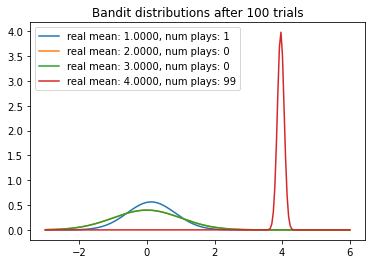

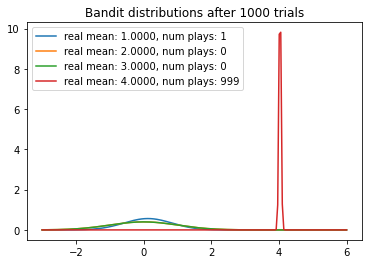

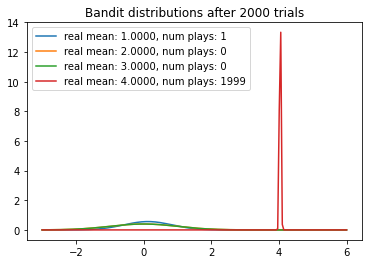

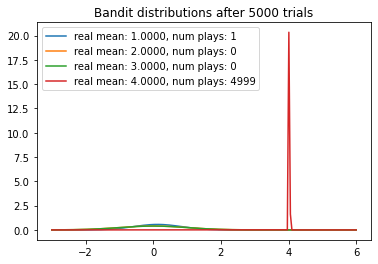

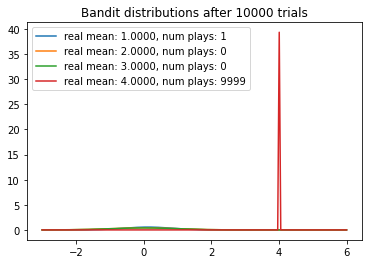

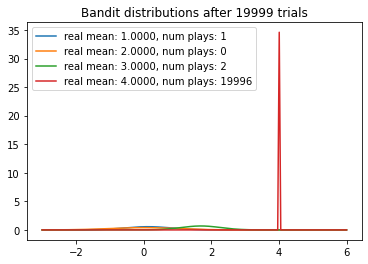

In [9]:
t_rewards, t_selected_bandit, bandits = ThompsonSampling(Bandit).experiment(BANDIT_REWARD)

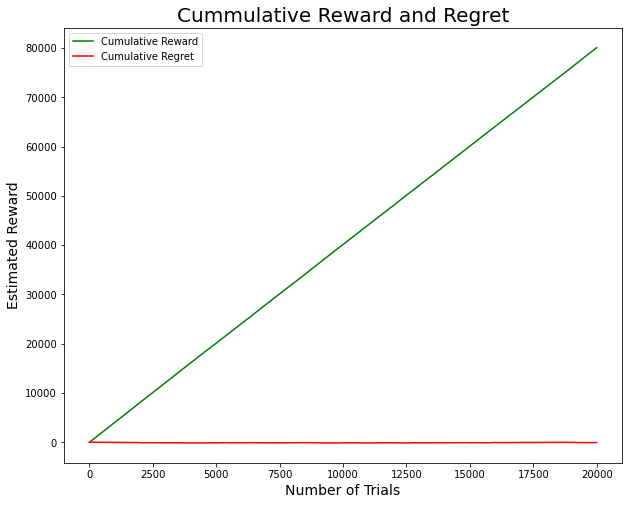

In [10]:
t_regrets = ThompsonSampling(Bandit).plot_learning_process(BANDIT_REWARD, t_rewards, t_selected_bandit)

In [11]:
df = ThompsonSampling(Bandit).report(bandits, t_rewards, t_regrets)

Cumulative Rewards: [2.53404920e-01 3.96917636e+00 6.92502996e+00 ... 8.00512971e+04
 8.00544792e+04 8.00600525e+04]
Cumulative Regrets: [ 3.74659508e+00  7.77741872e+00  1.28523888e+01 ... -1.78651002e+06
 -1.78656850e+06 -1.78662855e+06]

Average Rewards: 4.00300262642786
Average Regrets: -89.33142747594063


In [12]:
def comparison(epsilon_rewards, thompson_rewards):
    """
    Plot and compare the performance of two algorithms, Epsilon Greedy and Thompson Sampling,
    based on their cumulative rewards and mean reward per round.
    """
    # Plot cumulative rewards for each algorithm
    plt.figure(figsize=(10, 8))
    plt.plot(epsilon_rewards, label='Epsilon Greedy', alpha=0.75)
    plt.plot(thompson_rewards, label='Thompson Sampling', alpha=0.75)
    plt.title('Comparison of Epsilon Greedy and Thompson Sampling', fontsize=20)
    plt.xlabel('Round', fontsize=14)
    plt.ylabel('Cumulative Reward', fontsize=14)
    plt.legend()
    plt.show()

    # Plot mean reward per round for each algorithm
    epsilon_mean = [sum(epsilon_rewards[:i+1])/(i+1) for i in range(len(epsilon_rewards))]
    thompson_mean = [sum(thompson_rewards[:i+1])/(i+1) for i in range(len(thompson_rewards))]
    plt.figure(figsize=(10, 8))
    plt.plot(epsilon_mean, label='Epsilon Greedy')
    plt.plot(thompson_mean, label='Thompson Sampling')
    plt.title('Comparison of Epsilon Greedy and Thompson Sampling', fontsize=20)
    plt.xlabel('Round', fontsize=14)
    plt.ylabel('Mean Reward', fontsize=14)
    plt.legend()
    plt.show()

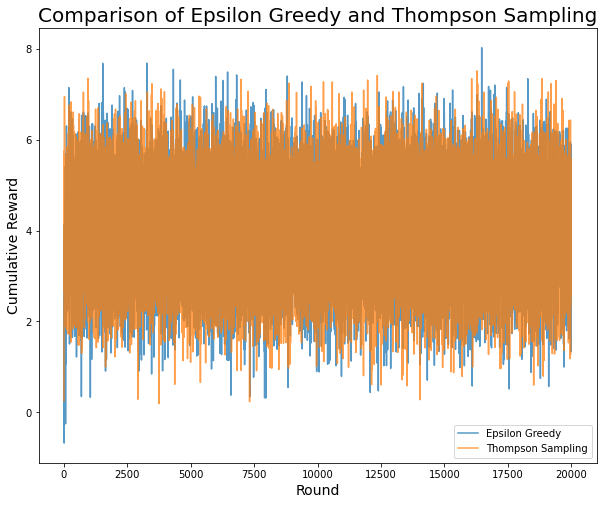

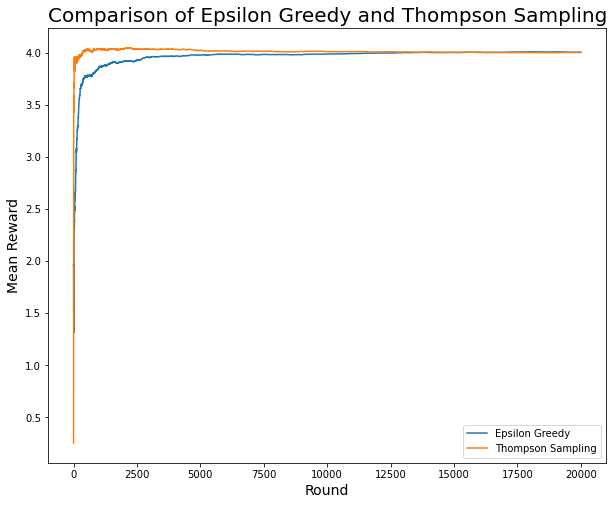

In [13]:
comparison(eg_rewards, t_rewards)

When it comes to choosing between Epsilon Greedy and Thompson Sampling, it ultimately depends on the specific problem and the desired trade-offs between exploration and exploitation. Both algorithms have their strengths and weaknesses, and their performance can vary depending on the specific circumstances.

In general, Epsilon Greedy is a simpler algorithm that is easier to implement and understand, and it can work well when the rewards are relatively consistent and the exploration rate is appropriately tuned. Thompson Sampling, on the other hand, is a more complex algorithm that takes into account uncertainty in the reward distributions, and it can perform better in situations where the rewards are more variable or when there is a high degree of uncertainty in the reward distributions.

Therefore, it is recommended to try both algorithms on a particular problem and evaluate their performance based on the specific criteria and constraints of that problem.